# PuGo Modeling
## Step 3: Optimizing Funds

The purpose of this script is to take data and models from Step 2 and run the genetic optimization algorithm for bucket values. First, bucket values will be created. Then the optimization will be run using DEAP.

### Goals

* Take gradient-boosting model for predictions and create buckets
* Run genetic algorithm for optimization
* Export optimized buckets for use later


### Process

* A. Load data and modules
* B. Define optimiziation constraints
* C. Set up for predictions
* D. Look at how predictions fared
* E. Bucketization
* F. Create parse scholarship functions
* G. Create evaluation and mutation functions
* H. Create genetic operators
* I. Evolving the population
* J. Checking results
* K. Sai


### Resources

* https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/pareto-optimized-road-trip/optimized-state-capitols-trip.ipynb

## Part A - Load data and modules

### Part A1 - Load modules

In [549]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import random
import copy
from tqdm import tqdm

# Get data-munging libraries
from sklearn import preprocessing
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Genetic algorithm
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

### Part A2 - Load  objects and data
These are objects that are created in Step 2: Enrollment Predictions

In [554]:
df = pd.read_csv('../predictions/forOpt/data_all.csv') #data used for the predictive model

In [552]:
model_location = '../predictions/forOpt/boosting_model.pkl' #the gradient boosting model

with open(model_location, 'rb') as model_input:
    predict_model = pickle.load(model_input)

In [553]:
scaler_location = '../predictions/forOpt/scaler.pkl' #the scaler used. Will be scaling/re-scaling in this code

with open(scaler_location, 'rb') as scaler_input:
    scaler = pickle.load(scaler_input)

In [555]:
# features not used in predictions but are needed in this script
df[['PuGoOffer', 'GrantSchol', 'Tuition', 'ApplYr', 'IsAdmitted']] = pd.read_csv('../predictions/forOpt/pugoTuitionAndGrants.csv')

In [556]:
#names of columns for the predictive model
col_location = '../predictions/forOpt/columns.pkl'

with open(col_location, 'rb') as col_input:
    cols = pickle.load(col_input)

In [557]:
cutoff_location = '../predictions/forOpt/best_cutoff.pkl' #cutoff when setting thresholds for predictions

cutoff_threshold = 0.5 #default cutoff

useCutoff = True #use the one determined from model

use_only_admitted = True #should be kept true unless wanting to analyze students not given an offer

if useCutoff: #should be used, in most cases
    with open(cutoff_location, 'rb') as cutoff_input:
        cutoff_threshold = pickle.load(cutoff_input)
        cutoff_threshold = cutoff_threshold + cutoff_tol

In [558]:
df.columns #some sanity checks below

Index([u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI',
       ...
       u'LowerHighSchoolGPA', u'UpperHighSchoolGPA', u'isAdmittedProbs',
       u'isAdmittedPredict', u'Enrolled', u'PuGoOffer', u'GrantSchol',
       u'Tuition', u'ApplYr', u'IsAdmitted'],
      dtype='object', length=113)

In [559]:
cols

Index([u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI',
       ...
       u'ed_3m', u'ed_4m', u'ed_5m', u'AcademicScore_imputed',
       u'tuition_after_grants', u'AcademicRankPctYr', u'LowerHighSchoolGPA',
       u'UpperHighSchoolGPA', u'isAdmittedProbs', u'isAdmittedPredict'],
      dtype='object', length=107)

In [560]:
predict_model.get_params() #parameters for models

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 1,
 'warm_start': False}

## Part B - Define optimization constraints

In [550]:
years_to_use = [2017] #year(s) to include in optimization

In [551]:
save_results = True #whether to save results
use_previous = False #whether to build off previous iterations of optimization

cutoff_tol = 0 #this is used to play with different cutoff tolerances for optimization vs prediction. 0 means no change.

fund_amount = 3500000 * 0.97 #total amount to be spent. The second term is in reference to how much is yet to be awarded
fund_amount = fund_amount * len(years_to_use) #total pool of funding available

max_offer_amount_scaler = 10 #scaler to multiply fund amount by for offers. In the past, offers have been 10x expected
min_offer_amount_scaler = 0.95 #scaler to set a floor on the amount of funds to use. This ensures we don't underspend

maximum_student_enrollment = 2100 #maximum number of students we'd want to have enroll

change_tuition = False
new_tuition = 37290 #tuition value to use if change_tuition is true. To experiment with different values
#36234, 37290, 38739

check_pct_targets = True #to check whether we give a suitable number of students a scholarship
schol_pct_target_min = 0.2 #min % of students to award a scholarship
schol_pct_target_max = 0.75 #max % of students to award a scholarship

#scholarship_amounts = np.arange(3000, 10000, 100)

scholarship_amounts = np.append([0], np.arange(3000, 9000, 300)) #these are all different scholarship buckets that were tried
#scholarship_amounts = [0, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
#scholarship_amounts = [0,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
max_scholarship = max(scholarship_amounts)

number_of_buckets = 20 #remember - these may not be unique

## Part C - Set up for predictions

In [561]:
df = df[df.ApplYr.isin(years_to_use)] #use only years of interest

In [562]:
#optimize only on admitted students
if use_only_admitted:
    df = df[df.isAdmittedPredict == 1] 

In [563]:
#x and y variables in predictions
y = df.Enrolled
x = df.drop('Enrolled', axis = 1)

In [564]:
#some sanity checks follow
x.tuition_after_grants.describe()

count     9485.000000
mean     31585.115973
std       2561.856050
min       4912.000000
25%      31038.000000
50%      32288.000000
75%      32288.000000
max      35538.000000
Name: tuition_after_grants, dtype: float64

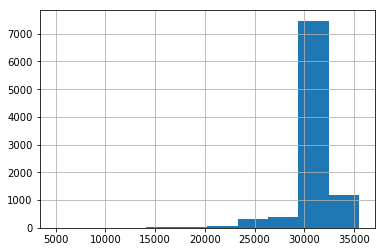

In [565]:
x.tuition_after_grants.hist()

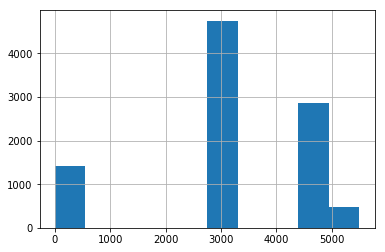

In [566]:
x.PuGoOffer.hist()

In [567]:
x.PuGoOffer.value_counts()

3250    4746
4500    2854
0       1418
5500     467
Name: PuGoOffer, dtype: int64

In [568]:
scalerValues = pd.Series(scaler.scale_)
scalerValues.index = cols
centerValues = pd.Series(scaler.center_)
centerValues.index = cols

In [569]:
if change_tuition:
    df['Tuition'] = new_tuition
    x['Tuition'] = new_tuition

In [570]:
rescale = True #this is important - rescale the data to fit what is expected for the prediction models

if rescale:
    x_scaled = pd.DataFrame(scaler.transform(x[cols]), index = x.index, columns = cols)

## Part D - Look at how predictions fared

### See how predictions fared

In [571]:
enrollProb = predict_model.predict_proba(x_scaled)[:,1] #probabilities for enrollment
enrollPrediction = enrollProb >= cutoff_threshold #use cutoff threshold

In [572]:
#these values are actual amounts from the historical data
actual_pugo_offered = df.PuGoOffer.sum()
print 'PuGo Offered: ' + str(actual_pugo_offered)

actual_pugo_use = df[df.Enrolled == 1].PuGoOffer.sum()
print 'PuGo Use: ' + str(actual_pugo_use)

print 'PuGo use %: ' + str(float(actual_pugo_use) / actual_pugo_offered * 100)

PuGo Offered: 30836000
PuGo Use: 3221000
PuGo use %: 10.4455830847


In [573]:
#these values are the predicted amounts for the given PuGo offers. Note how much there is an underestimation.
predicted_pugo_offered = df.PuGoOffer.sum()
print 'Predicted PuGo Offered: ' + str(predicted_pugo_offered)

predicted_pugo_use = df[enrollPrediction == 1].PuGoOffer.sum()
print 'Predicted PuGo Use: ' + str(predicted_pugo_use)

print 'Predicted PuGo use %: ' + str(float(predicted_pugo_use) / predicted_pugo_offered * 100)

Predicted PuGo Offered: 30836000
Predicted PuGo Use: 2298750
Predicted PuGo use %: 7.45476066935


In [574]:
#actual student enrollment counts
actual_student_count = df.Enrolled.sum()
actual_total_student_count = len(df)

print 'Enrolled students: ' + str(actual_student_count)
print 'Admitted students: ' + str(actual_total_student_count)
print 'Actual yield: ' + str(actual_student_count * 100.0 / actual_total_student_count)

Enrolled students: 1143
Admitted students: 9485
Actual yield: 12.0506062203


In [575]:
#predicted student enrollment counts
predicted_student_count = enrollPrediction.sum()
total_student_count = len(enrollPrediction)

print 'Predicted students: ' + str(predicted_student_count)
print 'Admitted students: ' + str(total_student_count)
print 'Predicted yield: ' + str(predicted_student_count * 100.0 / total_student_count)

Predicted students: 928
Admitted students: 9485
Predicted yield: 9.78386926726


In [576]:
predicted_net_revenue = (df.Tuition.mean() * enrollPrediction).sum()
print 'Predicted Net Revenue: ' + str(predicted_net_revenue) #predicted revenue, where revenue is just sum of tuition spent

Predicted Net Revenue: 32979264.0


In [577]:
predicted_avg_sat = df.TestScore[enrollPrediction == 1].mean()
print 'Predicted Average SAT: ' + str(predicted_avg_sat)

Predicted Average SAT: 1315.86853448


In [578]:
use_scaler = predicted_pugo_use * 1.0 / actual_pugo_use #if there should be some scaling with respect to how much PuGo is used
use_scaler = 1.0

## Part E - Bucketization

* Useful resources, https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb
* https://github.com/DEAP/notebooks/blob/master/SIGEvolution.ipynb
* http://deap.readthedocs.io/en/master/tutorials/basic/part1.html

In [579]:
#sort the students based on the below variables. These are ordered - sort by order of variables provided and 
#if tie, use the next variable, and so on
df = df.sort_values(['HolisticAcademicScore', 'HS_GPA', 'TestScore', 'AcademicScore_imputed', 'AcademicRankPctYr'], na_position = 'last')
df['BucketRank'] = np.arange(len(df))
df['Bucket'] = pd.cut(df['BucketRank'], number_of_buckets, labels = False)

In [580]:
df.Bucket.value_counts() #make sure every bucket has the expected number of students

0     475
14    475
9     475
4     475
19    475
10    474
8     474
16    474
1     474
17    474
2     474
15    474
18    474
7     474
11    474
12    474
5     474
13    474
6     474
3     474
Name: Bucket, dtype: int64

In [581]:
#this will give a sense for how the breakdown of buckets happened. Check this output(!!!)
mins = df.groupby('Bucket')['HolisticAcademicScore', 'HS_GPA', 'TestScore'].min()
maxes = df.groupby('Bucket')['HolisticAcademicScore', 'HS_GPA', 'TestScore'].max()
minsMaxes = mins.join(maxes, rsuffix = '_max', lsuffix = '_min')
minsMaxes

HolisticAcademicScore_min  HS_GPA_min  TestScore_min  \
Bucket                                                         
0                               0        0.01          740.0   
1                              13        3.53          926.0   
2                              13        3.73          960.0   
3                              13        3.28         1110.0   
4                              14        3.64         1098.0   
5                              14        3.70         1150.0   
6                              14        3.75         1110.0   
7                              14        3.79         1020.0   
8                              14        3.83         1040.0   
9                              14        3.86         1070.0   
10                             14        3.89         1070.0   
11                             14        3.93         1030.0   
12                             14        3.97         1060.0   
13                             14        3.45         1150.0   
14                             16        3.78         1190.0   
15                             16        3.87         1161.0   
16                             16        3.92         1040.0   
17                             16        3.96         1150.0   
18                             16        3.99         1030.0   
19                             16        3.72         1140.0   

        HolisticAcademicScore_max  HS_GPA_max  TestScore_max  
Bucket                                                        
0                              13        4.00         1580.0  
1                              13        3.73         1600.0  
2                              13        4.00         1560.0  
3                              14        4.00         1600.0  
4                              14        3.70         1600.0  
5                              14        3.75         1560.0  
6                              14        3.79         1560.0  
7                              14        3.83         1600.0  
8                              14        3.86         1600.0  
9                              14        3.89         1580.0  
10                             14        3.93         1600.0  
11                             14        3.97         1600.0  
12                             14        4.00         1560.0  
13                             16        4.00         1600.0  
14                             16        3.87         1600.0  
15                             16        3.92         1600.0  
16                             16        3.96         1600.0  
17                             16        3.99         1600.0  
18                             16        4.00         1600.0  
19                             18        4.00         1600.0

In [582]:
#prints the stats for each bucket. Again, more sanity checks to ensure we're working as expected
for i in range(0, number_of_buckets):
    high_school_gpa = df.HS_GPA[df['Bucket'] == i].sum()
    min_high_school_gpa = df.HS_GPA[df['Bucket'] == i].quantile(0.2)
    max_high_school_gpa = df.HS_GPA[df['Bucket'] == i].quantile(0.8)
    test_score = df.TestScore[df['Bucket'] == i].sum()
    min_test_score = df.TestScore[df['Bucket'] == i].quantile(0.2)
    max_test_score = df.TestScore[df['Bucket'] == i].quantile(0.8)
    academic_score = df.HolisticAcademicScore[df['Bucket'] == i].mean()
    holistic_1 = df.HolisticPQAScore[df['Bucket'] == i].quantile(0.99)
    holistic_2 = df.HolisticAdmissionScore[df['Bucket'] == i].quantile(0.99)
    efc = df.EFC[df['Bucket'] == i].sum()
    students = df.HS_GPA[df['Bucket'] == i].count()
    
    printString = ['bucket: ', str(i), '; students: ', str(students), '; academic score: ', str(academic_score), 
                   '; HS GPA: ', str(high_school_gpa*1.0/students), 
     ' - ', str(min_high_school_gpa), '/', str(max_high_school_gpa), '; tests: ', str(test_score*1.0/students),
     ' - ', str(min_test_score), '/', str(max_test_score), '; scores: ', str(academic_score*1.0 / students),
     ' - ', str(efc*1.0/students), '/', str(holistic_1), '/', str(holistic_2)]
    print  ''.join(printString)

bucket: 0; students: 475; academic score: 8.90105263158; HS GPA: 3.62905263158 - 3.45/3.91; tests: 1292.72421053 - 1140.0/1460.0; scores: 0.0187390581717 - 44105.44/16.0/16.0
bucket: 1; students: 474; academic score: 13.0; HS GPA: 3.64206751055 - 3.59/3.69; tests: 1349.13080169 - 1260.0/1423.8; scores: 0.0274261603376 - 59323.5379747/11.0/13.0
bucket: 2; students: 474; academic score: 13.0; HS GPA: 3.8385443038 - 3.77/3.92; tests: 1261.80379747 - 1160.0/1350.0; scores: 0.0274261603376 - 42039.4725738/11.0/13.0
bucket: 3; students: 474; academic score: 13.9535864979; HS GPA: 3.59793248945 - 3.54/3.63; tests: 1437.89873418 - 1378.8/1510.0; scores: 0.0294379461981 - 55286.3607595/10.0/14.0
bucket: 4; students: 475; academic score: 14.0; HS GPA: 3.67743157895 - 3.66/3.7; tests: 1411.47368421 - 1340.0/1475.2; scores: 0.0294736842105 - 50619.7705263/10.0/14.0
bucket: 5; students: 474; academic score: 14.0; HS GPA: 3.72687763713 - 3.71/3.74; tests: 1383.16455696 - 1300.0/1460.0; scores: 0.029

## Part F - Parse scholarship functions

Note: the code in this part may be the most important code in the entire notebook (project?)

### Part F1 - Make secondary functions

In [583]:
def reconstruct(valuesIn, tag):
    #get unscaled values from scaled values
    return (valuesIn * scalerValues[tag]) + centerValues[tag]

In [584]:
def deconstruct(valuesIn, tag):
    #get scaled values from unscaled values
    return (valuesIn - centerValues[tag]) / scalerValues[tag]

In [585]:
#this function will be used to evaluate scholarship amounts
def reCalculateTuition(dfIn):
    output = dfIn.copy() #copy input so as to not overwrite
    output['tuition_after_grants'] = output['Tuition'] - (output['PuGoOffer'] + output['GrantSchol']) #recalculate tuition
    output.loc[output.tuition_after_grants < 0, 'tuition_after_grants'] = 0
    output['tuition_after_grants'] = deconstruct(output['tuition_after_grants'], 'tuition_after_grants') #rescale!!
    return output 

In [586]:
opt_x = x_scaled.copy() #opt_x will be what we use in optimizations
opt_x[['PuGoOffer', 'GrantSchol', 'Tuition']] = df[['PuGoOffer', 'GrantSchol', 'Tuition']] #add these data variables
opt_x['Bucket'] = df['Bucket'] #add bucket values

In [587]:
test = reCalculateTuition(opt_x)['tuition_after_grants']
(test - opt_x.tuition_after_grants).describe() #this should all be zero - a sanity check

count    9485.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: tuition_after_grants, dtype: float64

In [589]:
opt_x['PredictionScore'] = predict_model.predict_proba(opt_x[cols])[:, 1] #generate initial prediction scores
opt_x['PredictionScoreTemp'] = opt_x['PredictionScore']
opt_x['EnrollPredictionTemp'] = predict_model.predict(opt_x[cols])

In [590]:
opt_x.loc[opt_x.PredictionScoreTemp < cutoff_threshold, 'EnrollPredictionTemp'] = 0 #look at initial predictions
opt_x.loc[opt_x.PredictionScoreTemp >= cutoff_threshold, 'EnrollPredictionTemp'] = 1
len(opt_x[opt_x['EnrollPredictionTemp'] == 1])

928

In [591]:
opt_x['EnrollPredictionTemp'].describe()

count    9485.000000
mean        0.097839
std         0.297112
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: EnrollPredictionTemp, dtype: float64

In [592]:
df['PuGoOffer'].describe()

count    9485.000000
mean     3251.027939
std      1516.157095
min         0.000000
25%      3250.000000
50%      3250.000000
75%      4500.000000
max      5500.000000
Name: PuGoOffer, dtype: float64

### Part F2 - Make scholarship evaluation function

In [593]:
def parse_scholarships_base(buckets, model, dfIn = opt_x, cutoff = cutoff_threshold, include_bucket_counts = False):
    dfHold = dfIn.copy() #again, make a copy so original doesn't get altered
    buckets = list(buckets) #convert to list (from DEAP type)
    
    for i in range(len(buckets)): #for each bucket
        bucket_amount = buckets[i] #pugo offer amount for each bucket gets assigned
        dfHold.loc[dfHold.Bucket == i, 'PuGoOffer'] = bucket_amount
    
    dfHold = reCalculateTuition(dfHold) #we then recalculate tuition (and rescale)
    
    dfHold['PredictionScoreTemp'] = predict_model.predict_proba(dfHold[cols])[:, 1] #recalculate predictions
    dfHold.loc[dfHold.PredictionScoreTemp >= cutoff, 'EnrollPredictionTemp'] = 1
    dfHold.loc[dfHold.PredictionScoreTemp < cutoff, 'EnrollPredictionTemp'] = 0

    students = len(dfHold[dfHold['EnrollPredictionTemp'] == 1]) #students who we predict will enroll
    scholarship_used = dfHold['PuGoOffer'][dfHold['EnrollPredictionTemp'] == 1].sum() / use_scaler #the amount of scholarhip we use
    students_with_scholarships = len(dfHold[dfHold['PuGoOffer'] > 0]) #the number of students who get a scholarship offer
    scholarships_offered = dfHold['PuGoOffer'].sum() #the total amount of scholarship offered

    tuition_revenue =  (dfHold['Tuition'] * dfHold['EnrollPredictionTemp']).sum() #revenue from tuition
    test_scores = reconstruct(dfHold.TestScore, 'TestScore') #this will make more sense if they are unscaled
    avg_test_score = test_scores[dfHold['EnrollPredictionTemp'] == 1].mean() #mean test score
    if np.isnan(avg_test_score): #will be null if there are no students
        avg_test_score = 0
    total_students = len(dfHold)
    
    if include_bucket_counts: #this tag will print out information on a bucket by bucket basis
        for i in range(len(buckets)): #for each bucket
            bucket_students = dfHold.EnrollPredictionTemp[(dfHold['EnrollPredictionTemp'] == 1) & (dfHold['Bucket'] == i)].count()
            bucket_scholarship_offered = dfHold.PuGoOffer[dfHold['Bucket'] == i].sum()
            bucket_scholarship_used = dfHold.PuGoOffer[(dfHold['EnrollPredictionTemp'] == 1) & (dfHold['Bucket'] == i)].sum() / use_scaler
            bucket_revenue = bucket_students * dfHold[dfHold['Bucket'] == i]['Tuition'].mean()
            bucket_test_score = test_scores[(dfHold['EnrollPredictionTemp'] == 1) & (dfHold['Bucket'] == i)].sum()
            bucket_total_students = dfHold.EnrollPredictionTemp[dfHold['Bucket'] == i].count()
            
            printString = ''.join(['Bucket: ', str(i), '; students: ', str(bucket_students), '; scholarships offered: ', 
                                  str(bucket_scholarship_offered), '; scholarships used: ', 
                                  str(bucket_scholarship_used), '; test score: ', str(np.divide(bucket_test_score * 1.0, bucket_students * 1.0)), 
                                  '; student %age: ', str(np.divide(bucket_students * 1.0, bucket_total_students))])
            
            print printString
        print '\n\n'
        
    # items to return (in this order):
    # net_revenue, scholarship_offered, scholarship_used, students, scholarship_pct, student_yield, avg_test_score
    return tuition_revenue - scholarship_used, scholarships_offered, scholarship_used, students, students_with_scholarships * 1.0 / total_students, students * 1.0 / total_students, avg_test_score

In [595]:
#skeleton function to call - essentially just has defaults to use built-in. Can be changed depending on style
def parse_scholarships(buckets, model, cutoff = cutoff_threshold, dfIn = opt_x):
    return parse_scholarships_base(buckets, model, dfIn, cutoff, False)

## Part G - Create evaluation and mutation functions
### Part G1 - Create the evaluation function

In [596]:
def eval_scholarships(bucket_combo):
    #these will be returned from the function created above
    net_revenue, scholarship_offered, scholarship_used, students, scholarship_pct, student_yield, avg_test_score = parse_scholarships(bucket_combo, predict_model)#, cutoff = 0.5)
    
    # create baselines on what to return
    net_revenue_to_return = net_revenue
    students_to_return = students
    
    # scalers for how much we must offer - both a max and a min
    max_offer_amount = fund_amount * max_offer_amount_scaler
    min_offer_amount = max_offer_amount * min_offer_amount_scaler
       
    penalty = 1.0 #penalty term. Can be changed for more/less harsh penalties. This will be continually modified below
    scaler = 1.0 #keep as float!!
    
    #we use square penalties here
    if scholarship_used > fund_amount: #if we spend more on pugo than we'd like
        penalty = penalty * np.square(fund_amount * scaler * 0.75 / scholarship_used)
    if scholarship_offered > max_offer_amount: #if we offer more pugo than we'd like
        penalty = penalty * np.square(max_offer_amount  * scaler * 0.75 / scholarship_offered)
    if scholarship_offered < min_offer_amount: #if we offer less pugo than we'd like (this is so we don't underspend)
        penalty = penalty * np.square(scholarship_offered  * scaler / min_offer_amount)
    if students > maximum_student_enrollment: #if we enroll too many students
        penalty = penalty * np.square(maximum_student_enrollment  * scaler / students)
    
    if check_pct_targets: #if we want to look at how many students are being offered pugo awards
        numerator = 1
        denominator = 1
        if scholarship_pct < schol_pct_target_min: #we set a numerator/denominator depending on the scenario
            numerator = scholarship_pct * scaler
            denominator = schol_pct_target_min 
        if scholarship_pct > schol_pct_target_max:
            numerator = schol_pct_target_max * scaler 
            denominator = scholarship_pct
        if denominator == 0:
            denominator = 1
        penalty = penalty * np.square(numerator / denominator) #change the penalty accordingly

    net_revenue_to_return = net_revenue_to_return * penalty #objective is to maximize this value. Penalty lowers it
    #students_to_return = students_to_return * penalty #could be used but found that maximizing revenue seems to work better
    
    return net_revenue_to_return, avg_test_score

### Part G2 - Create the mutation function

In [597]:
def compare_lists(x, y): #essentially returns if two lists are equal
    return 1 if len(frozenset(x).intersection(y)) == max(len(x),len(y)) else 0

In [600]:
#Make a single function that takes a scholarship 'bucket list' 
#and *changes* it to something very similar but not exactly the same
def mutation_operator(bucket_combo):
    """
        This function applies a random change to one set of scholarships
        
            - Init: create a bucket with 20 '0' values if it's not the right size
            - Increase: Add a scholarship to a random bucket
            - Reduce: Reduce a scholarship in a random bucket
            - Swap: Swaps the scholarship amounts of two buckets
    """
    possible_mutations = ['swap'] #we only start with a swap mutation
    original_combo = list(bucket_combo) #original bucket list
    bucket_list = list(bucket_combo) #this will be modified
    itercount = 0 #loop tracker
    
    while compare_lists(original_combo, bucket_list) > 0: #keep going if it's not the same
        itercount = itercount + 1
        if np.min(bucket_combo) < np.max(scholarship_amounts): #if reasonable, add a reduce and increase mutation
            possible_mutations.append('increase')
        if np.max(bucket_combo) > np.min(scholarship_amounts):
            possible_mutations.append('reduce')

        mutation_type = random.sample(possible_mutations, 1)[0]

        # Increase mutation
        if mutation_type == 'increase':
            to_increase = True
            while to_increase:
                index_to_increase = random.randint(0, number_of_buckets - 1)
                if bucket_combo[index_to_increase] < (max_scholarship):
                    bucket_combo[index_to_increase] = np.random.choice([amt for amt in scholarship_amounts if amt > bucket_combo[index_to_increase]],1)[0]
                    to_increase = False
        
        # Reduce mutation
        elif mutation_type == 'reduce':
            index_to_delete = random.randint(0, number_of_buckets - 1)
            if bucket_combo[index_to_delete] > np.min(scholarship_amounts):
                bucket_combo[index_to_delete] = np.random.choice([amt for amt in scholarship_amounts if amt < bucket_combo[index_to_delete]],1)[0]
        
        # Swap mutation
        elif mutation_type == 'swap':
            index1 = random.randint(0, number_of_buckets - 1)
            index2 = index1
            while index2 == index1:
                index2 = random.randint(0, number_of_buckets - 1)
                if bucket_combo[index1] == bucket_combo[index2]:
                    index2 = index1
            bucket_combo[index1], bucket_combo[index2] = bucket_combo[index2], bucket_combo[index1]

        bucket_combo.sort()
        bucket_list = list(bucket_combo)
    # now that things are sorted, return the result
    bucket_combo.sort()
    return bucket_combo,

## Part H - Create genetic operators
### Part H1 - Create the initial attribute functions

In [601]:
def random_scholarshipAmount():
    return np.random.choice(scholarship_amounts, 1)[0]

In [602]:
def random_individual():
    random_buckets = np.random.choice(scholarship_amounts, size = number_of_buckets, replace = True).tolist()
    random_buckets.sort()
    return creator.Individual(random_buckets)

### Part H2 - Type creation

**From Dev**

First step with DEAP is to create the required types. Usually the types created are the fitness and the individual. For the OneMax problem, we want to have a solution with as many ones as possible. Thus we need a maximizing fitness and a individual that is a sorted container, we'll choose the standard list.

Type creation is done by calling the function create in the creator module. This function takes two mandatory arguments and additional optional arguments. The first argument is the actual name of the type that we want to create. The second argument is the base classe that the new type created should inherit from. Finally, the optional arguments are members to add to the new type.

In [1]:
creator.create('FitnessMulti', base.Fitness, weights=(0.99, 0.01)) #we are going to weight in favor of revenue mainly
creator.create('Individual', list, fitness=creator.FitnessMulti)

#creator.create('FitnessMax', base.Fitness, weights=(1.0))
#creator.create('Individual', list, fitness=creator.FitnessMax)

NameError: name 'creator' is not defined

**From Dev**

The toolbox is intended to store functions with their arguments under standard aliases for uses in algorithms. Functions are registered by a function call with two mandatory arguments, the alias to give to the function and the function it will be associate with. Any additional argument will be given as argument when the alias is called.

In [604]:
toolbox = base.Toolbox() #this will be used to build things. First, build a bucket, then a bucket list, then a population

In [605]:
toolbox.register("attr_scholarshipAmount", random_scholarshipAmount)

In [606]:
bit = toolbox.attr_scholarshipAmount()
print("bit is of type %s and has value\n%s" % (type(bit), bit))

bit is of type <type 'numpy.int32'> and has value
8100


In [607]:
toolbox.register("individual", random_individual)

In [608]:
ind = toolbox.individual()
print("ind is of type %s and contains %d bits\n%s" % (type(ind), len(ind), ind))

ind is of type <class 'deap.creator.Individual'> and contains 20 bits
[0, 3000, 3600, 3900, 4200, 4800, 4800, 5100, 5700, 6000, 6000, 6300, 6300, 6300, 6600, 6600, 7800, 8100, 8700, 8700]


The same thing is done for the population function.

In [609]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [610]:
pop = toolbox.population(n = 3)
print("pop is of type %s and contains %d individuals\n%s" % (type(pop), len(pop), pop))

pop is of type <type 'list'> and contains 3 individuals
[[0, 3000, 3000, 3900, 4200, 4500, 4800, 5400, 6000, 6900, 6900, 7200, 7800, 7800, 8100, 8100, 8100, 8100, 8700, 8700], [3000, 3300, 3900, 3900, 4200, 4800, 4800, 4800, 5100, 6000, 6300, 6300, 6600, 6600, 6900, 6900, 8100, 8400, 8400, 8700], [0, 0, 0, 3000, 3000, 3300, 3600, 3600, 3900, 4200, 4500, 5100, 5100, 5100, 5700, 6300, 6300, 7200, 7200, 8700]]


### Part H3 - Register genetic operators

In [611]:
toolbox.register('evaluate', eval_scholarships) #evaluation operator; based on previously created eval scholarships function

In [612]:
#test the evaluation
ind = toolbox.individual() #create and individual and evaluate it
evaluation = toolbox.evaluate(ind)
print("Eval is of type %s and contains \n%s" % (type(evaluation), evaluation))

Eval is of type <type 'tuple'> and contains 
(720406.78528514632, 1322.7178658043654)


In [613]:
toolbox.register("mate", tools.cxTwoPoint) #crossover mutation

In [614]:
toolbox.register('mutate', mutation_operator) #we set the mutation operator to be based on our previously created funciton

## Part I - Evolving the population
### Part I1 - Create population and HOF

http://deap.readthedocs.io/en/master/api/algo.html

In [615]:
pop_size = 1000 #size of population to use

toolbox.register("select", tools.selTournament, tournsize = np.min([pop_size / 10, 5])) #register tournament

In [616]:
#this function will be used to generate a population
def create_population(size, prev = use_previous):
    pop = toolbox.population(n = size) #initial population
    float_buckets = number_of_buckets * 1.0 #multiplier is a float for conversion
    #manually adding cases to the population
    #found that having more extreme amounts works better in terms of convergence to better values
    pop[0] = creator.Individual([np.min(scholarship_amounts)] * number_of_buckets) #all mins
    pop[1] = creator.Individual([np.max(scholarship_amounts)] * number_of_buckets) #all maxes
    pop[2] = creator.Individual([np.median(scholarship_amounts)] * number_of_buckets) #all medians
    pop[3] = creator.Individual([np.partition(scholarship_amounts, 1)[1]] * number_of_buckets) #take second smallest value
    #go half zeros and half mins
    pop[4] = creator.Individual(([0] * int(np.ceil(float_buckets / 2))) + [np.partition(scholarship_amounts, 1)[1]] * int(np.floor(float_buckets / 2)))
    if prev: #this is whether we want to build off previous iterations/populations. Starting from scratch is usually a good idea
        bucket_string = str(number_of_buckets)
        ind_file = 'bestInds/' + bucket_string + '.pkl'
        with open(ind_file, 'rb') as ind_input:
            pop[5] = pickle.load(ind_input)
        print 'Using previous'
    return pop

In [617]:
pop = create_population(pop_size, False)

In [618]:
np.array(pop[4]) #sanity check on how things are working

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000])

In [619]:
hof = tools.HallOfFame(1) #this is the hall of fame. Here is where the best models are tracked
stats = tools.Statistics(lambda ind: ind.fitness.values) #these are the stats we want to keep track of for each iteration
stats.register("max", np.max)
stats.register("mean", np.mean)
stats.register("median", np.median)
stats.register("min", np.min)

### Part I2 - Evolution

In [622]:
#this where the population will evolve
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb = 0.5, mutpb = 0.5, ngen = 20, stats = stats, halloffame = hof, verbose = True)

gen	nevals	max        	mean  	median 	min
0  	1000  	1.04758e+07	467252	1330.49	0  
1  	743   	1.34526e+07	893796	294254 	1309.44
2  	748   	1.38373e+07	1.64806e+06	533385 	1308.85
3  	737   	1.4414e+07 	3.01335e+06	776695 	1308.85
4  	742   	1.4414e+07 	4.68265e+06	762302 	1308.72
5  	742   	1.45584e+07	5.98419e+06	1.35243e+06	1308.72
6  	765   	1.45584e+07	6.33677e+06	1.39313e+06	1308.72
7  	736   	1.4781e+07 	6.74058e+06	1.6177e+06 	1308.72
8  	739   	1.4781e+07 	6.92032e+06	1.69155e+06	1309.55
9  	768   	1.50608e+07	6.99973e+06	3.65818e+06	1310.87
10 	745   	1.51511e+07	7.21205e+06	3.53114e+06	1311.71
11 	740   	1.52153e+07	7.22378e+06	3.93313e+06	1311.98
12 	778   	1.52582e+07	7.32867e+06	3.99276e+06	1311.67
13 	772   	1.53155e+07	7.46605e+06	4.05036e+06	1314.66
14 	758   	1.53155e+07	7.49935e+06	4.10756e+06	1317.86
15 	782   	1.53205e+07	7.44083e+06	4.08633e+06	1317.97
16 	698   	1.53335e+07	7.46765e+06	4.08633e+06	1317.97
17 	746   	1.53335e+07	7.47213e+06	4.1601e+06 	1317.97
18

In [623]:
best = hof[0] #this is the individual that performed the best
best.sort() #sort the values (sometimes things got unexplanably jumbled)
print best
print toolbox.evaluate(best)

#parse the scholarships using the best individual and see results
net_revenue, scholarship_offered, scholarship_used, students, scholarship_pct, student_yield, avg_test_score = parse_scholarships_base(best, predict_model, cutoff = 0.5)
print students
print students * 1.0 / predicted_student_count

[0, 0, 0, 0, 0, 3000, 3000, 3000, 3300, 3300, 3300, 3300, 4200, 4200, 5700, 5700, 6300, 7200, 7200, 8400]
(15256458.0, 1318.986051502146)
261
1.01162790698


Best individual is: [0, 0, 0, 0, 0, 3000, 3000, 3000, 3300, 3300, 3300, 3300, 4200, 4200, 5700, 5700, 6300, 7200, 7200, 8400] with fitness: (15353772.0, 1319.2889125799575)

Bucket, Students, ScholarshipUsed, NetRevenue, AvgTestScore, Yield
Bucket: 0; students: 146; scholarships offered: 0; scholarships used: 0.0; test score: 1188.60958904; student %age: 0.307368421053
Bucket: 1; students: 87; scholarships offered: 0; scholarships used: 0.0; test score: 1335.7816092; student %age: 0.183544303797
Bucket: 2; students: 49; scholarships offered: 0; scholarships used: 0.0; test score: 1222.42857143; student %age: 0.103375527426
Bucket: 3; students: 41; scholarships offered: 0; scholarships used: 0.0; test score: 1418.97560976; student %age: 0.0864978902954
Bucket: 4; students: 25; scholarships offered: 0; scholarships used: 0.0; test score: 1378.96; student %age: 0.0526315789474
Bucket: 5; students: 79; scholarships offered: 1422000; scholarships used: 237000.0; test score: 1336.79746835; s

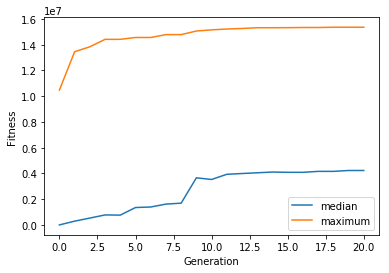

In [624]:
#print out information on the best individual
print"Best individual is: %s with fitness: %s" % (best, best.fitness)

print '\nBucket, Students, ScholarshipUsed, NetRevenue, AvgTestScore, Yield'
net_revenue, scholarship_offered, scholarship_used, students, scholarship_pct, student_yield, avg_test_score = parse_scholarships_base(best, predict_model, include_bucket_counts = True)
#print ('Evaluation of best individual:', parse_scholarships(hof[0]))
print 'Evaluation of best individual detailed: '

new_revenue = (students * df['Tuition'].mean())
print 'Net Revenue is ' + str(new_revenue) + ' (' + str(np.round(new_revenue * 1.0 / 1000000, 4)) + ' mil)'
print 'Scholarship Offered is ' + str(scholarship_offered) + ' (' + str(np.round(scholarship_offered * 1.0 / 1000000, 4)) + ' mil)'
print 'Scholarship Used is ' + str(scholarship_used) + ' (' + str(np.round(scholarship_used * 1.0 / 1000000, 4)) + ' mil)'
print 'Student Count is ' + str(students)
print 'Offer Pct is ' + str(scholarship_pct)
print 'Student Yield is ' + str(student_yield)
print 'Average Test Score is ' + str(avg_test_score)

#plot model evolution
gen, median, max_ = logbook.select("gen", "median", "max")
plt.plot(gen, median, label="median")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [627]:
#save best model
if save_results:
    bucket_string = str(len(best))
    ind_file = 'bestInds/' + bucket_string + '.pkl'
    with open(ind_file, 'wb') as output:
        pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved best'

Saved best


# Check results

In [151]:
def evaluateBucketsVsPrevious(bucketIn, changeCutoff = False):
    tol = 0
    if changeCutoff:
        tol = cutoff_tol
    bucketDF = pd.DataFrame({'newPugoAmount' : bucketIn, 'Bucket' : range(len(bucketIn))})
    temp = x_scaled.copy()
    temp[['PuGoOffer', 'GrantSchol', 'Tuition', 'Bucket']] = df[['PuGoOffer', 'GrantSchol', 'Tuition', 'Bucket']]
    temp = temp.merge(bucketDF, on = 'Bucket', how = 'left')
    
    temp['IsEnrolledOrMatriculated'] = df.Enrolled
    temp['PredictionScore'] = predict_model.predict_proba(temp[cols])[:, 1]
    temp['OldPredictions'] = temp['PredictionScore'] >= cutoff_threshold - tol
    temp['TuitionAfterGrantsOld'] = temp.tuition_after_grants
    temp['tuition_after_grants'] = temp['Tuition'] - temp['newPugoAmount'] - temp['GrantSchol']
    temp['tuition_after_grants'] = deconstruct(temp['tuition_after_grants'], 'tuition_after_grants')
    temp['NewPredictionScore'] = predict_model.predict_proba(temp[cols])[:, 1]
    temp['NewPredictions'] = temp['NewPredictionScore'] >= cutoff_threshold - tol
    
    old_student_counts = temp['OldPredictions'].sum()
    new_student_counts = temp['NewPredictions'].sum()
    old_pugo_offer = temp['PuGoOffer'].sum()
    new_pugo_offer = temp['newPugoAmount'].sum()
    old_pugo_used = (temp['PuGoOffer'] * temp['OldPredictions']).sum()
    new_pugo_used = (temp['newPugoAmount'] * temp['NewPredictions']).sum()
    
    return old_student_counts, old_pugo_offer, old_pugo_used, new_student_counts, new_pugo_offer, new_pugo_used

In [152]:
def evaluateBuckets(bucketIn, changeCutoff = False):
        
    tol = 0
    if changeCutoff:
        tol = cutoff_tol
    bucketDF = pd.DataFrame({'newPugoAmount' : bucketIn, 'Bucket' : range(len(bucketIn))})
    temp = x_scaled.copy()
    
    temp = temp.sort_values(['HolisticAcademicScore', 'HS_GPA', 'TestScore', 'AcademicScore_imputed', 'AcademicRankPctYr'], ascending = False)
    temp['BucketRank'] = np.arange(len(temp))[::-1]
    temp['Bucket'] = pd.cut(temp['BucketRank'], len(bucketIn), labels = False)
    
    temp[['PuGoOffer', 'GrantSchol', 'Tuition']] = df[['PuGoOffer', 'GrantSchol', 'Tuition']]
    temp = temp.merge(bucketDF, on = 'Bucket', how = 'left')
    
    temp['IsEnrolledOrMatriculated'] = df.Enrolled
    temp['tuition_after_grants'] = temp['Tuition'] - temp['newPugoAmount'] - temp['GrantSchol']
    temp['tuition_after_grants'] = deconstruct(temp['tuition_after_grants'], 'tuition_after_grants')
    temp['NewPredictionScore'] = predict_model.predict_proba(temp[cols])[:, 1]
    temp['NewPredictions'] = temp['NewPredictionScore'] >= cutoff_threshold - tol
    
    new_student_counts = temp['NewPredictions'].sum()
    new_pugo_offer = temp['newPugoAmount'].sum()
    new_pugo_used = (temp['newPugoAmount'] * temp['NewPredictions']).sum()
    
    return new_student_counts, new_pugo_offer, new_pugo_used

In [153]:
evaluateBucketsVsPrevious(best, True)

(1155, 30836000L, 2927250L, 1063, 34997800L, 3189800L)

In [406]:
evaluateBuckets(pop[0], True)

(913, 28549200L, 1842200L)

In [ ]:
evaluateBuckets(pop[0], True)

In [407]:
best

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 3000,
 3000,
 3100,
 3400,
 5000,
 5000,
 5000,
 5100,
 5100,
 5300,
 5300,
 5700,
 6200]

In [428]:
crafted = [
 0,
 0,
 0,
 0,
 0,
 0,
 1500,
 2400,
 3300,
 3300,
 3300,
 5100,
 5100,
 5100,
 5400,
 5400,
 5400,
 5400,
 5700,
 6600]

parse_scholarships_base(crafted, predict_model, include_bucket_counts = True)

Bucket: 0; students: 152; scholarships offered: 0; scholarships used: 0.0; test score: 1203.48684211; student %age: 0.32
Bucket: 1; students: 107; scholarships offered: 0; scholarships used: 0.0; test score: 1332.17757009; student %age: 0.225738396624
Bucket: 2; students: 59; scholarships offered: 0; scholarships used: 0.0; test score: 1231.03389831; student %age: 0.12447257384
Bucket: 3; students: 47; scholarships offered: 0; scholarships used: 0.0; test score: 1406.65957447; student %age: 0.0991561181435
Bucket: 4; students: 30; scholarships offered: 0; scholarships used: 0.0; test score: 1378.73333333; student %age: 0.0631578947368
Bucket: 5; students: 50; scholarships offered: 0; scholarships used: 0.0; test score: 1343.96; student %age: 0.105485232068
Bucket: 6; students: 31; scholarships offered: 711000; scholarships used: 51166.2823469; test score: 1345.77419355; student %age: 0.0654008438819
Bucket: 7; students: 21; scholarships offered: 1137600; scholarships used: 55457.647963

(30799908.68562644,
 29877300L,
 2015291.3143735589,
 880,
 0.6999472851871376,
 0.09277807063784924,
 1313.725)

In [415]:
check_scenarios = True

In [416]:
evaluateBuckets(crafted, True)

(885, 28691600L, 1770300L)

In [417]:
if check_scenarios:
    nums = []
    others = []
    directory = 'bestInds/'
    files = os.listdir(directory)
    for each in files:
        split = each.split('_')
        nums.append(int(split[0]))
        others.append('_'.join(split[1:]).split('.')[0])
    nums = list(set(nums))
    nums.sort()
    others = list(set(others))
    outputs = {}
    for each in others:
        currentDict = {}
        toUse = [x for x in files if each in x]
        for ind in toUse:
            ind_file = directory + ind
            with open(ind_file, 'rb') as ind_input:
                current = pickle.load(ind_input)
            num = int(ind.split('_')[0])
            currentDict[num] = evaluateBuckets(current)[0]
        outputs[each] = currentDict

In [ ]:
with open('bestInds/', 'rb') as ind_input:
    c = pickle.load(ind_input)

In [418]:
outputs

{'2percent': {20: 1296},
 '3percent': {20: 1259},
 '3percent2': {20: 1259},
 '4percent': {20: 1176},
 'capSixty': {5: 885, 10: 886, 20: 885},
 'capSixty_largeGrain': {5: 885, 10: 886, 20: 885},
 'everybodyWins': {5: 775, 10: 772, 20: 841},
 'final55': {20: 869},
 'final65': {20: 926},
 'lowFloor': {5: 766, 10: 775, 20: 766},
 'lowFloor_largeGrain': {5: 766, 10: 775, 20: 766},
 'moreFunds': {5: 1047, 10: 1176, 20: 1174},
 'original': {5: 1044, 10: 1044, 20: 1172}}

In [102]:
toUse

['10_original.pkl', '20_original.pkl', '5_original.pkl']

In [92]:
others

['capSixty',
 'capSixty_largeGrain',
 'everybodyWins',
 'lowFloor',
 'lowFloor_largeGrain',
 'moreFunds',
 'original',
 'capSixty',
 'capSixty_largeGrain',
 'everybodyWins',
 'lowFloor',
 'lowFloor_largeGrain',
 'moreFunds',
 'original',
 'capSixty',
 'capSixty_largeGrain',
 'everybodyWins',
 'lowFloor',
 'lowFloor_largeGrain',
 'moreFunds',
 'original']

# Look at scenarios

In [79]:
# First, let's alter the maximum amount awarded
fund_amounts = np.arange(2, 5.1, 0.25) * 1000000
store = []
pop_size_new = 500
for each in fund_amounts:
    hof2 = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("mean", np.mean)
    stats.register("median", np.median)
    stats.register("min", np.min)

    fund_amount = each
    pop = create_population(pop_size_new, False)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb = 0.8, mutpb = 0.8, ngen = 20, stats = stats, halloffame = hof2, verbose = True)
    store.append(hof2[0])
    print evaluateBucketsVsPrevious(hof2[0])

gen	nevals	max        	mean   	median 	min
0  	500   	1.33682e+07	31796.4	1382.25	0  
1  	480   	2.15236e+07	123554 	9083.66	1307.98
2  	480   	2.72732e+07	238689 	20047.1	1306.52
3  	480   	2.72732e+07	714902 	33054.4	1309.19
4  	477   	2.7339e+07 	2.58884e+06	88015.9	1308.46
5  	481   	2.86606e+07	7.20303e+06	376242 	1308.46
6  	486   	2.86606e+07	1.13025e+07	3.35002e+06	1308.46
7  	480   	2.86606e+07	1.28425e+07	2.3059e+06 	1308.61
8  	476   	2.86606e+07	1.27671e+07	2.33466e+06	1315.24
9  	481   	2.86606e+07	1.25766e+07	2.26781e+06	1325.23
10 	477   	2.86606e+07	1.24412e+07	2.67859e+06	1325.23
11 	488   	2.86606e+07	1.39507e+07	2.67859e+06	1325.23
12 	476   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
13 	483   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
14 	477   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
15 	479   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
16 	479   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
17 	480   	2.86606e+07	1.4331e+07 	1.4331e+07 	1338.8 
18 	481   	

In [80]:
evaluateBucketsVsPrevious(hof2[0], False)

(967, 30851250L, 2317000L, 1225, 45161400.0, 4995600.0)

In [81]:
evals = []
for each in [best] + store:
    evals.append(evaluateBucketsVsPrevious(each))
    print evaluateBucketsVsPrevious(each)

(967, 30851250L, 2317000L, 1087, 29936000L, 3036400L)
(967, 30851250L, 2317000L, 896, 19220000L, 1925400L)
(967, 30851250L, 2317000L, 911, 22134000L, 2035300L)
(967, 30851250L, 2317000L, 967, 23779000L, 2447500L)
(967, 30851250L, 2317000L, 1028, 27069000L, 2697600L)
(967, 30851250L, 2317000L, 1078, 29560000L, 2989900L)
(967, 30851250L, 2317000L, 1113, 30923000L, 3235100L)
(967, 30851250L, 2317000L, 1134, 34071800L, 3488400L)
(967, 30851250L, 2317000L, 1159, 36045300L, 3727100L)
(967, 30851250L, 2317000L, 1186, 38018800L, 3978000L)
(967, 30851250L, 2317000L, 1212, 40415400L, 4202300L)
(967, 30851250L, 2317000L, 1179, 42765200.0, 4492400.0)
(967, 30851250L, 2317000L, 1225, 45161800.0, 4748800.0)
(967, 30851250L, 2317000L, 1225, 45161400.0, 4995600.0)


In [82]:
fund_amount

5000000.0

In [83]:
evaluateBucketsVsPrevious([4000] * 20)

(967, 30851250L, 2317000L, 1152, 37596000L, 4608000L)

In [84]:
if save_results:
    ind_file = 'changingFundAmounts/buckets.pkl'
    with open(ind_file, 'wb') as output:
        pickle.dump(store, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved buckets'
    
    ind_file = 'changingFundAmounts/fund_amounts.pkl'
    with open(ind_file, 'wb') as output:
        pickle.dump(fund_amounts, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved fund amounts'
    
    ind_file = 'changingFundAmounts/evals.pkl'
    with open(ind_file, 'wb') as output:
        pickle.dump(evals, output, pickle.HIGHEST_PROTOCOL)
    print 'Saved evaluations'

Saved buckets
Saved fund amounts
Saved evaluations


In [85]:
equal_amounts = []
for each in fund_amounts[:1]:
    for value in np.arange(0, 100000, 10):
        current = [value] * number_of_buckets
        check = evaluateBucketsVsPrevious(current)
        if check[5] > each:
            break
    equal_amounts.append(check)